In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dropout
import matplotlib.pyplot as plt
from util import plot_history
import feature_builder

Cargo datasets

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
kernel_size=1
strides=4

Armo features con el feature_builder

In [4]:
def prepare_for_cnn(df):
    processed = feature_builder.process_dataset(df)
    return processed.to_numpy().reshape(processed.shape[0], kernel_size, processed.shape[1])

In [5]:
X_train = prepare_for_cnn(train_df)
y_train = train_df['target'].values

Creo el modelo y corro la CNN

In [6]:
def create_model():
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=kernel_size, strides=strides, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Epoch 1/40
191/191 [==============================] - 1s 3ms/step - loss: 0.7368 - accuracy: 0.5711 - val_loss: 0.6212 - val_accuracy: 0.7085
Epoch 2/40
191/191 [==============================] - 0s 2ms/step - loss: 0.6077 - accuracy: 0.6691 - val_loss: 0.6090 - val_accuracy: 0.6402
Epoch 3/40
191/191 [==============================] - 0s 1ms/step - loss: 0.5631 - accuracy: 0.7261 - val_loss: 0.5421 - val_accuracy: 0.7223
Epoch 4/40
191/191 [==============================] - 0s 1ms/step - loss: 0.5129 - accuracy: 0.7649 - val_loss: 0.4811 - val_accuracy: 0.7768
Epoch 5/40
191/191 [==============================] - 0s 1ms/step - loss: 0.4985 - accuracy: 0.7736 - val_loss: 0.4704 - val_accuracy: 0.7873
Epoch 6/40
191/191 [==============================] - 0s 1ms/step - loss: 0.4871 - accuracy: 0.7849 - val_loss: 0.4658 - val_accuracy: 0.7932
Epoch 7/40
191/191 [==============================] - 0s 1ms/step - loss: 0.4815 - accuracy: 0.7828 - val_loss: 0.4407 - val_accuracy: 0.8017
Epoch 

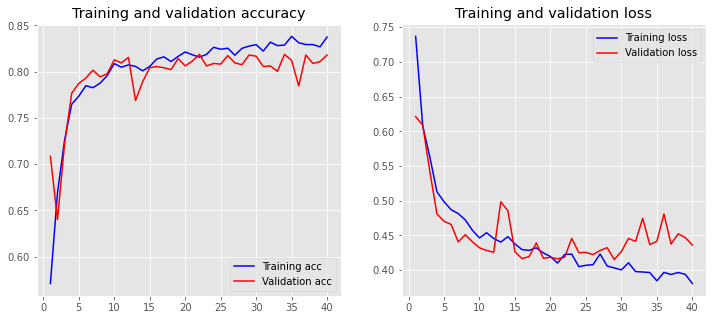

In [7]:
model = create_model()
history = model.fit(X_train, y_train, epochs=40, shuffle=True, validation_split=0.2)
plot_history(history)

Vemos cuales fallo

In [8]:
prediction = model.predict_classes(X_test)
df = pd.DataFrame({'text': test, 'target': y_test, 'prediction': [x[0] for x in prediction]})

NameError: name 'X_test' is not defined

In [ ]:
pd.set_option('display.max_rows', len(df))
pd.set_option('display.max_colwidth', None)
df[df['target'] != df['prediction']]

In [ ]:
df[df['target'] == df['prediction']]

Calculemos el test para kaggle

In [ ]:
ids = test_df['id']

final_test = prepare_for_cnn(test_df)
prediction = model.predict_classes(final_test)

final_df = pd.DataFrame({'target': [x[0] for x in prediction]}, index=ids)
final_df

In [ ]:
final_df['target'].value_counts()

In [ ]:
final_df.count()

In [ ]:
final_df.to_csv('cnn.csv')